
# Gas Supply-Demand Modeling

This notebook presents a comprehensive workflow for **supply-demand modeling** in the Gas and LNG (Liquefied Natural Gas) market.  
It includes:
- Data preprocessing & exploratory data analysis (EDA)
- Causality, Granger, and elasticity tests
- Feature engineering & model building
- Evaluation and insights

---


# Supply–Demand Modelling of German Gas & LNG

**Author:** Mohit Kumar

## Project summary

This notebook develops a monthly supply–demand and pricing model for Germany’s natural gas and LNG market, combining multiple open data sources into a single analytical framework. It integrates data from **Eurostat (imports, consumption), AGSI (storage & LNG terminals), EIA (supply/export flows, HH spot price), and global price benchmarks — TTF, JKM, Henry Hub, and Brent.**

The pipeline harmonizes all datasets to a **consistent monthly frequency**, ensuring comparability across supply, demand, storage, and price drivers. It then performs **data cleaning, correlation and causality testing, and baseline predictive modeling** to reveal how **supply fundamentals and external prices influence Germany’s gas market balance.**

Through **EDA and model evaluation**, the notebook highlights:



*   Strong **seasonality in German gas demand**, linked to heating cycles and storage withdrawals.
*   The **interaction between LNG imports, storage levels, and price spreads (TTF–JKM–HH).**


*   How **global gas and oil-linked price signals** can help explain and anticipate **German demand shifts.**

# Objectives & Methodology

Objectives

*   Build a unified monthly dataset of Germany’s gas supply, demand, and storage.

*   Integrate LNG and benchmark price data (TTF, JKM, Henry Hub, Brent).


*   Analyze correlations and causal relationships between fundamentals and prices.

*   Develop baseline ML models to explain/forecast demand and pricing trends.

Methodology


*   Automated and manual data ingestion → cleaning → transformation → merging → modeling.

*   Consistent monthly time series using robust resampling.


*   EDA for seasonality, correlations, and drivers.

*   ML modeling + evaluation (MAE, RMSE).

## Table of Contents

1. Setup & Imports
2. Function Definition
3. Data transformationm and cleaning
4. Execution and column renaming for better understanding of data
4. Exploratory Data Analysis (EDA)
5. Feature Engineering and Supply Demand ML Model Pipeline
6. Scenario Simulation + SHAP Explainability

## 1) Setup & Imports

Install any missing packages in your environment (e.g., `eurostat`, `requests`, `scikit-learn`).

In [20]:
import pandas as pd
import numpy as np
import requests
import json
import os
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import joblib

## 2) Function Definition

In [21]:
def fetch_eurostat_gas_data():
    """
    Fetch and process Eurostat gas balance data from 2017-10 to 2025-03

    Returns:
        pd.DataFrame: Processed gas data with dates as rows and nrg_bal categories as columns
    """
    # Eurostat API URL for gas balance data
    gas_url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_cb_gasm/1.0/*.*.*.*.*?c[freq]=M&c[nrg_bal]=IPRD,TOS,IMP,EXP,STK_CHG_CG,STK_CHG_MG,INTMARB,IC_OBS,IC_CAL_MG,TI_EHG_MAP,DL,VENT,FLARE,FC_IND,FC_OTH,STATDIFF&c[siec]=G3000&c[unit]=MIO_M3&c[geo]=DE&startPeriod=2017-10&endPeriod=2025-03&compress=false&format=json&lang=en"

    # Make API request
    resp = requests.get(gas_url)
    json_gas = resp.json()

    # Extract values and dimensions from JSON response
    values = json_gas['value']
    dims = json_gas['dimension']

    # Get time periods and energy balance categories
    time_keys = list(dims['time']['category']['index'].keys())        # e.g., ['2024-01', '2024-02', ...]
    nrg_keys = list(dims['nrg_bal']['category']['index'].keys())      # e.g., ['IPRD', 'TOS', ...]

    # Reconstruct data rows from Eurostat's encoded format
    rows = []
    n_time = len(time_keys)
    for obs_id_str, val in values.items():
        obs_id = int(obs_id_str)
        time_idx = obs_id % n_time        # Time index from modulo operation
        nrg_idx = obs_id // n_time        # Energy balance index from integer division
        rows.append({
            'Date': pd.to_datetime(time_keys[time_idx]),
            'nrg_bal': nrg_keys[nrg_idx],
            'value': val
        })

    # Convert to DataFrame and pivot to wide format
    df_gas = pd.DataFrame(rows)
    df_gas = df_gas.pivot(index='Date', columns='nrg_bal', values='value').reset_index()

    return df_gas


def fetch_eurostat_hdd_data():
    """
    Fetch and process Eurostat Heating Degree Days (HDD) data with forward filling for 2025

    Returns:
        pd.DataFrame: HDD data with complete monthly series from 2017-10 to 2025-03
    """
    # Eurostat API URL for HDD data
    hdd_url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_chdd_m/1.0/*.*.*.*?c[freq]=M&c[unit]=NR&c[indic_nrg]=HDD&c[geo]=DE&c[TIME_PERIOD]=2024-12,2024-11,2024-10,2024-09,2024-08,2024-07,2024-06,2024-05,2024-04,2024-03,2024-02,2024-01,2023-12,2023-11,2023-10,2023-09,2023-08,2023-07,2023-06,2023-05,2023-04,2023-03,2023-02,2023-01,2022-12,2022-11,2022-10,2022-09,2022-08,2022-07,2022-06,2022-05,2022-04,2022-03,2022-02,2022-01,2021-12,2021-11,2021-10,2021-09,2021-08,2021-07,2021-06,2021-05,2021-04,2021-03,2021-02,2021-01,2020-12,2020-11,2020-10,2020-09,2020-08,2020-07,2020-06,2020-05,2020-04,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,2018-03,2018-02,2018-01,2017-12,2017-11,2017-10&compress=false&format=json&lang=en"

    # Make API request
    resp_hdd = requests.get(hdd_url)
    data_hdd = resp_hdd.json()

    # Extract values and dimensions
    hdd_values = data_hdd['value']
    dims_hdd = data_hdd['dimension']
    time_keys_hdd = list(dims_hdd['time']['category']['index'].keys())

    # Create complete date range from 2017-10 to 2025-03
    full_date_range = pd.date_range(start='2017-10-01', end='2025-03-31', freq='ME')  # Month End frequency
    df_hdd_complete = pd.DataFrame({'Date': full_date_range})

    # Map HDD values to dates
    hdd_date_map = {}
    for obs_id_str, val in hdd_values.items():
        obs_id = int(obs_id_str)
        time_idx = obs_id % len(time_keys_hdd)
        date_key = time_keys_hdd[time_idx]  # e.g., '2024-01'
        hdd_date_map[date_key] = val

    # Assign HDD values based on date strings
    df_hdd_complete['Date_str'] = df_hdd_complete['Date'].dt.strftime('%Y-%m')
    df_hdd_complete['HDD'] = df_hdd_complete['Date_str'].map(hdd_date_map)
    df_hdd_complete = df_hdd_complete.drop('Date_str', axis=1)

    # For missing 2025 months, use average of same months from 2021-2024
    for month in [1, 2, 3]:  # January, February, March 2025
        # Calculate historical average for the same month
        historical_avg = df_hdd_complete[
            (df_hdd_complete['Date'].dt.month == month) &
            (df_hdd_complete['Date'].dt.year.between(2021, 2024))
        ]['HDD'].mean()

        # Apply to 2025 months
        mask = (df_hdd_complete['Date'].dt.month == month) & (df_hdd_complete['Date'].dt.year == 2025)
        df_hdd_complete.loc[mask, 'HDD'] = historical_avg

    # Forward fill any remaining missing values
    df_hdd_complete['HDD'] = df_hdd_complete['HDD'].ffill()

    return df_hdd_complete


def fetch_agsi_dataset(company, dataset):
    """
    Fetch AGSI storage or terminal data with caching mechanism

    Args:
        company (str): Company code or empty string for all companies
        dataset (str): Either "storage" or "terminal"

    Returns:
        pd.DataFrame: Processed monthly AGSI data
    """
    # API configuration
    API_KEY = "bf495800b66a69fd74e777de86ecc79a"
    BASE_URL = "https://agsi.gie.eu/api"
    headers = {"x-key": API_KEY}
    CACHE_DIR = "/tmp/agsi_cache"
    os.makedirs(CACHE_DIR, exist_ok=True)

    # Cache file path
    fname = os.path.join(CACHE_DIR, f"{dataset}_{company}_full.json")

    # Check if cached data exists
    if os.path.exists(fname):
        print(f"Loading cached {dataset} data...")
        with open(fname,'r') as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        print(f"Loaded {len(df)} records from cache")
    else:
        # Fetch data from API with pagination
        print(f"Fetching {dataset} data from API with pagination...")
        all_data = []

        # Fetch data in 1-year chunks from 2025 down to 2017
        for year in range(2025, 2016, -1):
            start_date = f"{year-1}-01-01"
            end_date = f"{year}-12-31"
            url = f"{BASE_URL}?country=DE&company={company}&size=1000&from={start_date}&to={end_date}"
            print(f"Fetching {start_date} to {end_date}")

            resp = requests.get(url, headers=headers)
            if resp.status_code != 200:
                print(f"API Error for {year}: {resp.text}")
                continue

            data = resp.json()
            chunk_data = data.get('data', [])
            print(f"Received {len(chunk_data)} records for {year}")

            if chunk_data:
                all_data.extend(chunk_data)

            # Small delay to be respectful to API
            import time
            time.sleep(0.5)

        if not all_data:
            print("No data received from API")
            return pd.DataFrame()

        df = pd.DataFrame(all_data)
        print(f"Total records received: {len(df)}")

        # Cache the full dataset
        with open(fname,'w') as f:
            json.dump(all_data, f)

    print(f"DataFrame shape: {df.shape}")

    # Process date column
    if 'gasDayStart' in df.columns:
        df['Date'] = pd.to_datetime(df['gasDayStart'], errors='coerce')
        print(f"Date range in raw data: {df['Date'].min()} to {df['Date'].max()}")
    else:
        print("No gasDayStart column found")
        return pd.DataFrame()

    # Convert numeric columns
    exclude_cols = ['Date', 'gasDayStart', 'gasDayEnd', 'name', 'code', 'url', 'info', 'status',
                   'publication_link', 'transparency_template', 'updatedAt']
    numeric_cols = [c for c in df.columns if c not in exclude_cols]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Set date index and sort
    df = df.set_index('Date').sort_index()

    # Define aggregation strategy for different column types
    level_columns = ['gasInStorage', 'workingGasVolume', 'injectionCapacity',
                    'withdrawalCapacity', 'contractedCapacity', 'full', 'availableCapacity']
    flow_columns = ['injection', 'withdrawal', 'netWithdrawal', 'trend']

    agg_dict = {}
    for col in df.columns:
        if col in level_columns and col in df.columns:
            agg_dict[col] = 'last'    # Use last value for level variables
        elif col in flow_columns and col in df.columns:
            agg_dict[col] = 'sum'     # Use sum for flow variables
        elif col not in exclude_cols:
            agg_dict[col] = 'first'   # Use first value for other variables

    # Resample to monthly frequency
    df_monthly = df.resample('ME').agg(agg_dict)

    print(f"Monthly data shape: {df_monthly.shape}")
    print(f"Monthly date range: {df_monthly.index.min()} to {df_monthly.index.max()}")

    return df_monthly.reset_index()


def clean_price_csv(path, colname):
    """
    Clean and resample price CSV data to monthly frequency

    Args:
        path (str): Path to CSV file
        colname (str): Column name for the price data

    Returns:
        pd.DataFrame: Cleaned price data with Date and price column
    """
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Find price column (case-insensitive search for columns starting with 'price')
    price_col = [c for c in df.columns if c.lower().startswith('price')][0]

    # Keep only Date and price columns, rename price column
    df = df[['Date', price_col]].rename(columns={price_col: colname})

    # Resample to monthly frequency using mean
    df = df.set_index('Date').resample('ME').mean().reset_index()

    return df


def fetch_price_data():
    """
    Fetch and merge all price data from various sources

    Returns:
        pd.DataFrame: Merged price data with TTF, JKM, Henry Hub, and Brent prices
    """
    # Load and clean various price datasets
    df_ttf = clean_price_csv("/content/drive/MyDrive/Dutch TTF Natural Gas Futures Historical Data (1).csv", "TTF_Price")
    df_jkm = clean_price_csv("/content/drive/MyDrive/LNG Japan_Korea Marker PLATTS Future Historical Data (1).csv", "JKM_Price")
    df_brent = clean_price_csv("/content/drive/MyDrive/Brent Oil Futures Historical Data.csv", "Brent_Price")

    # Fetch Henry Hub data from EIA Excel file
    hh_url = "https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls"
    df_hh = pd.read_excel(hh_url, sheet_name="Data 1", skiprows=2)
    df_hh['Date'] = pd.to_datetime(df_hh['Date'], errors='coerce')
    df_hh = df_hh[['Date','Henry Hub Natural Gas Spot Price (Dollars per Million Btu)']].rename(
        columns={'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'HH_Price'}
    )
    df_hh = df_hh.set_index('Date').resample('ME').mean().reset_index()

    # Merge all price datasets
    df_prices = df_ttf.merge(df_jkm, on="Date", how="outer")\
                       .merge(df_hh, on="Date", how="outer")\
                       .merge(df_brent, on="Date", how="outer")

    return df_prices


def merge_all_data(df_gas, df_storage, df_terminal, df_hdd_complete, df_prices):
    """
    Merge all datasets and perform final processing and cleaning

    Args:
        df_gas: Eurostat gas balance data
        df_storage: AGSI storage data
        df_terminal: AGSI terminal data
        df_hdd_complete: HDD data
        df_prices: Price data

    Returns:
        pd.DataFrame: Final merged and cleaned dataset
    """
    # Debug information before merge
    print("Before merge - checking HDD data:")
    print(f"df_hdd_complete shape: {df_hdd_complete.shape}")
    print(f"HDD non-null values: {df_hdd_complete['HDD'].notna().sum()}")
    print(f"Sample HDD values: {df_hdd_complete['HDD'].head()}")

    # Merge all dataframes using reduce for sequential merging
    dfs = [df_gas, df_storage, df_terminal, df_hdd_complete, df_prices]
    df_final2 = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dfs)

    print(f"\nAfter initial merge - df_final2 shape: {df_final2.shape}")
    print(f"HDD non-null values after merge: {df_final2['HDD'].notna().sum()}")

    # Drop fully empty columns (preserve HDD even if it has some NaN values)
    cols_to_drop = [c for c in df_final2.columns if c != 'Date' and c != 'HDD' and df_final2[c].isna().all()]
    df_final2 = df_final2.drop(columns=cols_to_drop)

    print(f"After dropping empty columns - shape: {df_final2.shape}")

    # Set Date as index for resampling
    df_final2 = df_final2.set_index('Date')

    # Define aggregation strategy for different column types
    agg_dict = {}
    for col in df_final2.columns:
        if 'Price' in col or 'HDD' in col:
            agg_dict[col] = 'mean'  # Use mean for prices and HDD (level variables)
        else:
            agg_dict[col] = 'sum'   # Use sum for gas volumes and storage flows (flow variables)

    # Resample to monthly frequency with appropriate aggregation
    df_final2 = df_final2.resample('ME').agg(agg_dict).reset_index()

    print(f"After resampling - shape: {df_final2.shape}")
    print(f"HDD non-null values after resampling: {df_final2['HDD'].notna().sum()}")

    # Sort by date and forward fill missing values
    df_final2 = df_final2.sort_values("Date")
    df_final2 = df_final2.ffill().reset_index(drop=True)  # Only forward fill, no backward fill

    print(f"After filling - shape: {df_final2.shape}")
    print(f"HDD non-null values after filling: {df_final2['HDD'].notna().sum()}")

    # Filter to desired date range
    start_date = pd.to_datetime("2017-10-01")
    end_date   = pd.to_datetime("2025-03-31")
    df_final2 = df_final2[(df_final2['Date'] >= start_date) & (df_final2['Date'] <= end_date)].reset_index(drop=True)

    print(f"After date filtering - shape: {df_final2.shape}")
    print(f"HDD non-null values after filtering: {df_final2['HDD'].notna().sum()}")

    # Drop columns where all values are 0 (but preserve HDD)
    cols_to_drop = [c for c in df_final2.columns if c != 'Date' and c != 'HDD' and (df_final2[c] == 0).all()]
    df_final2 = df_final2.drop(columns=cols_to_drop)

    # Final summary
    print(f"\nFinal dataset shape: {df_final2.shape}")
    print(f"Final columns: {df_final2.columns.tolist()}")

    # HDD validation
    if 'HDD' in df_final2.columns:
        print(f"✓ HDD in final dataset!")
        print(f"  - Non-null values: {df_final2['HDD'].notna().sum()}")
        print(f"  - Range: {df_final2['HDD'].min():.1f} to {df_final2['HDD'].max():.1f}")
        print(f"  - Sample values: {df_final2['HDD'].head(10).tolist()}")
    else:
        print("✗ HDD still missing from final dataset!")

    return df_final2


## 3) Data transformationm and cleaning

Load CSVs, API responses (Eurostat, AGSI, and EIA), and other raw sources. Ensure credentials / API keys are set as environment variables where required.

In [22]:
def main():
    """
    Main execution function that orchestrates the entire data pipeline
    """
    print("Starting Gas Market Data Pipeline...")
    print("=" * 50)

    # 1) Eurostat Gas Data
    print("\n1. Fetching Eurostat gas data...")
    df_gas = fetch_eurostat_gas_data()
    print(f"   Gas data shape: {df_gas.shape}")

    # 2) Eurostat HDD Data
    print("\n2. Fetching Eurostat HDD data...")
    df_hdd_complete = fetch_eurostat_hdd_data()
    print(f"   HDD data shape: {df_hdd_complete.shape}")

    # 3) AGSI Storage and Terminal Data
    print("\n3. Fetching AGSI storage and terminal data...")
    print("   Fetching storage data...")
    df_storage = fetch_agsi_dataset("37X000000000042Z", "storage")

    print("\n   Fetching terminal data...")
    df_terminal = fetch_agsi_dataset("37X000000000042Z", "terminal")

    # Fallback: If we don't have enough historical data, try without company filter
    if len(df_storage) < 24:
        print("\n   Trying without company filter to get more historical data...")
        df_storage_country = fetch_agsi_dataset("", "storage")
        df_terminal_country = fetch_agsi_dataset("", "terminal")

        if len(df_storage_country) > len(df_storage):
            df_storage = df_storage_country
            df_terminal = df_terminal_country

    # Filter to desired date range: October 2017 to March 2025
    start_date = pd.Timestamp('2017-10-01')
    end_date = pd.Timestamp('2025-03-31')

    df_storage = df_storage[(df_storage['Date'] >= start_date) & (df_storage['Date'] <= end_date)]
    df_terminal = df_terminal[(df_terminal['Date'] >= start_date) & (df_terminal['Date'] <= end_date)]

    print(f"\n   Filtered storage data: {len(df_storage)} months from {df_storage['Date'].min()} to {df_storage['Date'].max()}")
    print(f"   Filtered terminal data: {len(df_terminal)} months from {df_terminal['Date'].min()} to {df_terminal['Date'].max()}")

    # 4) Price Data
    print("\n4. Fetching price data...")
    df_prices = fetch_price_data()
    print(f"   Price data shape: {df_prices.shape}")

    # 5) Merge All Data
    print("\n5. Merging all datasets...")
    print("   " + "-" * 30)
    df_final = merge_all_data(df_gas, df_storage, df_terminal, df_hdd_complete, df_prices)

    print("\n" + "=" * 50)
    print("Pipeline completed successfully!")
    print("=" * 50)

    return df_final




## 4) Execution and column renaming for better understanding of data

In [23]:
# Execute the main function
if __name__ == "__main__":
    final_dataframe = main()

    # Create a dictionary for column renaming
    column_rename_map = {
        # Eurostat Gas Data
        'EXP': 'Gas_Exports',
        'IC_CAL_MG': 'Indigenous_Production_Calibrated',
        'IC_OBS': 'Indigenous_Production_Observed',
        'IMP': 'Gas_Imports',
        'IPRD': 'Indigenous_Production',
        'STK_CHG_MG': 'Stock_Changes',
        'TI_EHG_MAP': 'Total_Energy_Supply',

        # AGSI Storage Data (_x columns)
        'gasInStorage_x': 'Storage_GasInStorage_TWh',
        'injection_x': 'Storage_Injection_GWh',
        'withdrawal_x': 'Storage_Withdrawal_GWh',
        'netWithdrawal_x': 'Storage_NetWithdrawal_GWh',
        'workingGasVolume_x': 'Storage_WorkingGasVolume_TWh',
        'injectionCapacity_x': 'Storage_InjectionCapacity_GWh',
        'withdrawalCapacity_x': 'Storage_WithdrawalCapacity_GWh',
        'contractedCapacity_x': 'Storage_ContractedCapacity_TWh',
        'availableCapacity_x': 'Storage_AvailableCapacity_TWh',
        'trend_x': 'Storage_Trend',
        'full_x': 'Storage_Fill_Percent',

        # AGSI Terminal Data (_y columns)
        'gasInStorage_y': 'Terminal_GasInStorage_TWh',
        'injection_y': 'Terminal_Injection_GWh',
        'withdrawal_y': 'Terminal_Withdrawal_GWh',
        'netWithdrawal_y': 'Terminal_NetWithdrawal_GWh',
        'workingGasVolume_y': 'Terminal_WorkingGasVolume_TWh',
        'injectionCapacity_y': 'Terminal_InjectionCapacity_GWh',
        'withdrawalCapacity_y': 'Terminal_WithdrawalCapacity_GWh',
        'contractedCapacity_y': 'Terminal_ContractedCapacity_TWh',
        'availableCapacity_y': 'Terminal_AvailableCapacity_TWh',
        'trend_y': 'Terminal_Trend',
        'full_y': 'Terminal_Fill_Percent',

        # HDD and Price Data
        'HDD': 'Heating_Degree_Days',
        'TTF_Price': 'TTF_Gas_Price_EUR',
        'JKM_Price': 'JKM_LNG_Price_USD',
        'HH_Price': 'Henry_Hub_Price_USD',
        'Brent_Price': 'Brent_Oil_Price_USD'
    }

    # Apply the renaming to the actual dataframe
    df_final_cleaned = final_dataframe.rename(columns=column_rename_map)

    # Display the new column names and basic info
    print("Updated column names:")
    print(df_final_cleaned.columns.tolist())
    print(f"\nDataset shape: {df_final_cleaned.shape}")
    print(f"Date range: {df_final_cleaned['Date'].min()} to {df_final_cleaned['Date'].max()}")

Starting Gas Market Data Pipeline...

1. Fetching Eurostat gas data...
   Gas data shape: (139, 15)

2. Fetching Eurostat HDD data...
   HDD data shape: (90, 2)

3. Fetching AGSI storage and terminal data...
   Fetching storage data...
Loading cached storage data...
Loaded 2400 records from cache
DataFrame shape: (2400, 21)
Date range in raw data: 2017-03-07 00:00:00 to 2024-12-31 00:00:00
Monthly data shape: (94, 11)
Monthly date range: 2017-03-31 00:00:00 to 2024-12-31 00:00:00

   Fetching terminal data...
Loading cached terminal data...
Loaded 2700 records from cache
DataFrame shape: (2700, 21)
Date range in raw data: 2017-03-07 00:00:00 to 2025-10-08 00:00:00
Monthly data shape: (104, 11)
Monthly date range: 2017-03-31 00:00:00 to 2025-10-31 00:00:00

   Filtered storage data: 87 months from 2017-10-31 00:00:00 to 2024-12-31 00:00:00
   Filtered terminal data: 90 months from 2017-10-31 00:00:00 to 2025-03-31 00:00:00

4. Fetching price data...
   Price data shape: (345, 5)

5. Mer

## 5) Exploratory Data Analysis (EDA)

Visual checks, seasonality analysis, correlation matrices, and quick summaries.

In [24]:
# Basic stats
df_final_cleaned.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,90,2021-07-15 18:40:00,2017-10-31 00:00:00,2019-09-07 12:00:00,2021-07-15 12:00:00,2023-05-23 06:00:00,2025-03-31 00:00:00,NaN
Gas_Exports,90.0,4429.803878,343.333,1927.327,5469.3585,6235.3275,7830.737,2348.82716
Indigenous_Production_Calibrated,90.0,7233.984167,3017.858,4401.33325,6870.732,9888.4535,13130.666,2935.190814
Indigenous_Production_Observed,90.0,7233.984167,3017.858,4401.33325,6870.732,9888.4535,13130.666,2935.190814
Gas_Imports,90.0,11133.288044,4766.36,8405.34175,12139.433,13844.313,15329.096,3015.181226
Indigenous_Production,90.0,406.444444,269.0,344.25,408.0,455.75,589.0,76.424026
Stock_Changes,90.0,-124.055556,-6813.0,-1758.0,370.0,1714.0,4002.0,2288.379636
Total_Energy_Supply,90.0,1127.366667,0.0,785.5,1086.5,1415.0,1960.0,393.793234
Storage_GasInStorage_TWh,90.0,1.462057,0.0,0.58325,1.84795,2.248175,2.321,0.895095
Storage_Injection_GWh,90.0,129.068556,0.0,0.0125,62.455,179.9525,923.82,180.886395


### 5.1) EDA Part 1: Visuals (Trends, Storage, Seasonality, Spreads, Balances)EDA Part 1: Visuals (Trends, Storage, Seasonality, Spreads, Balances)

EXPLORATORY DATA ANALYSIS - GERMAN GAS MARKET (PART 1: VISUALS)

Time period: Oct 2017 to Mar 2025
Rows: 90 | Columns: 33
Missing values (total): 0


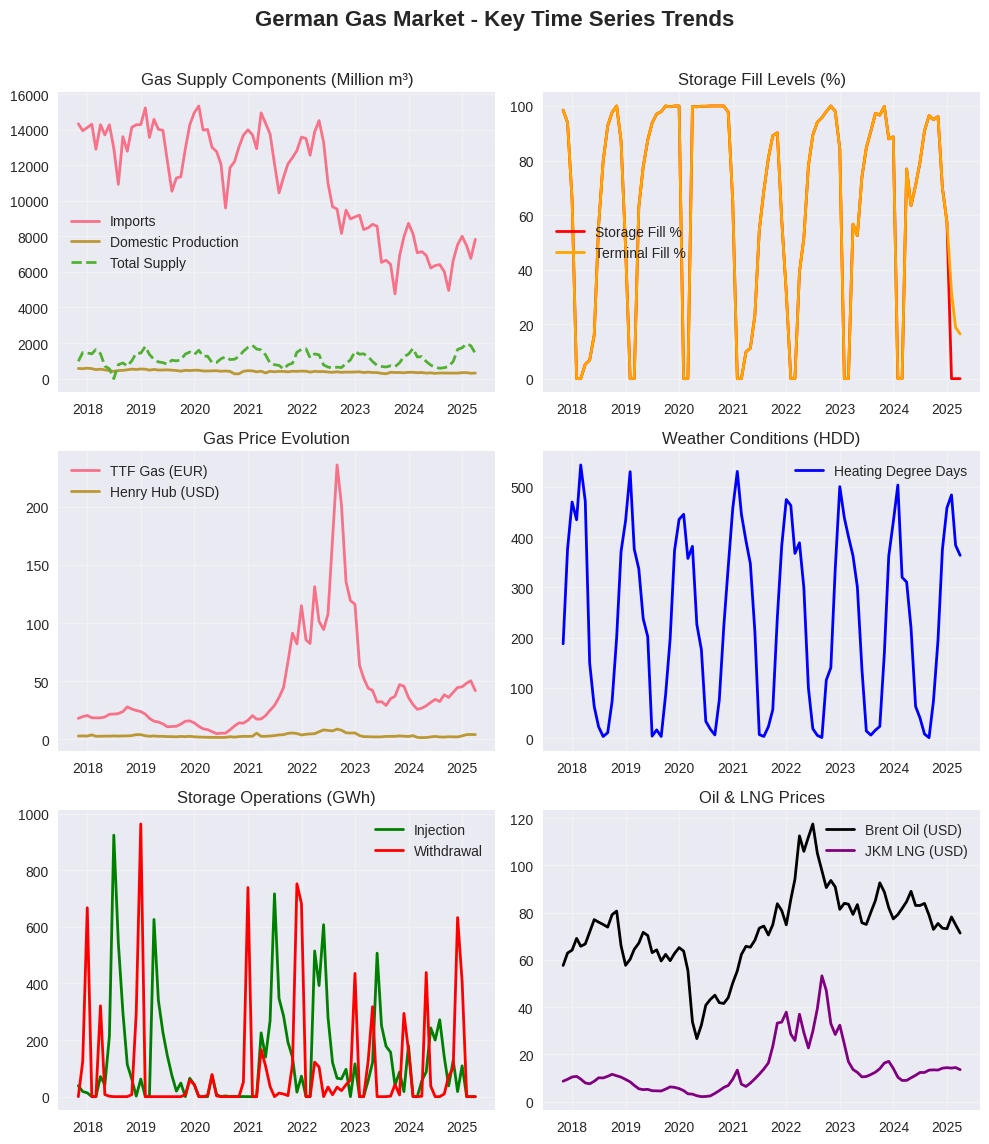

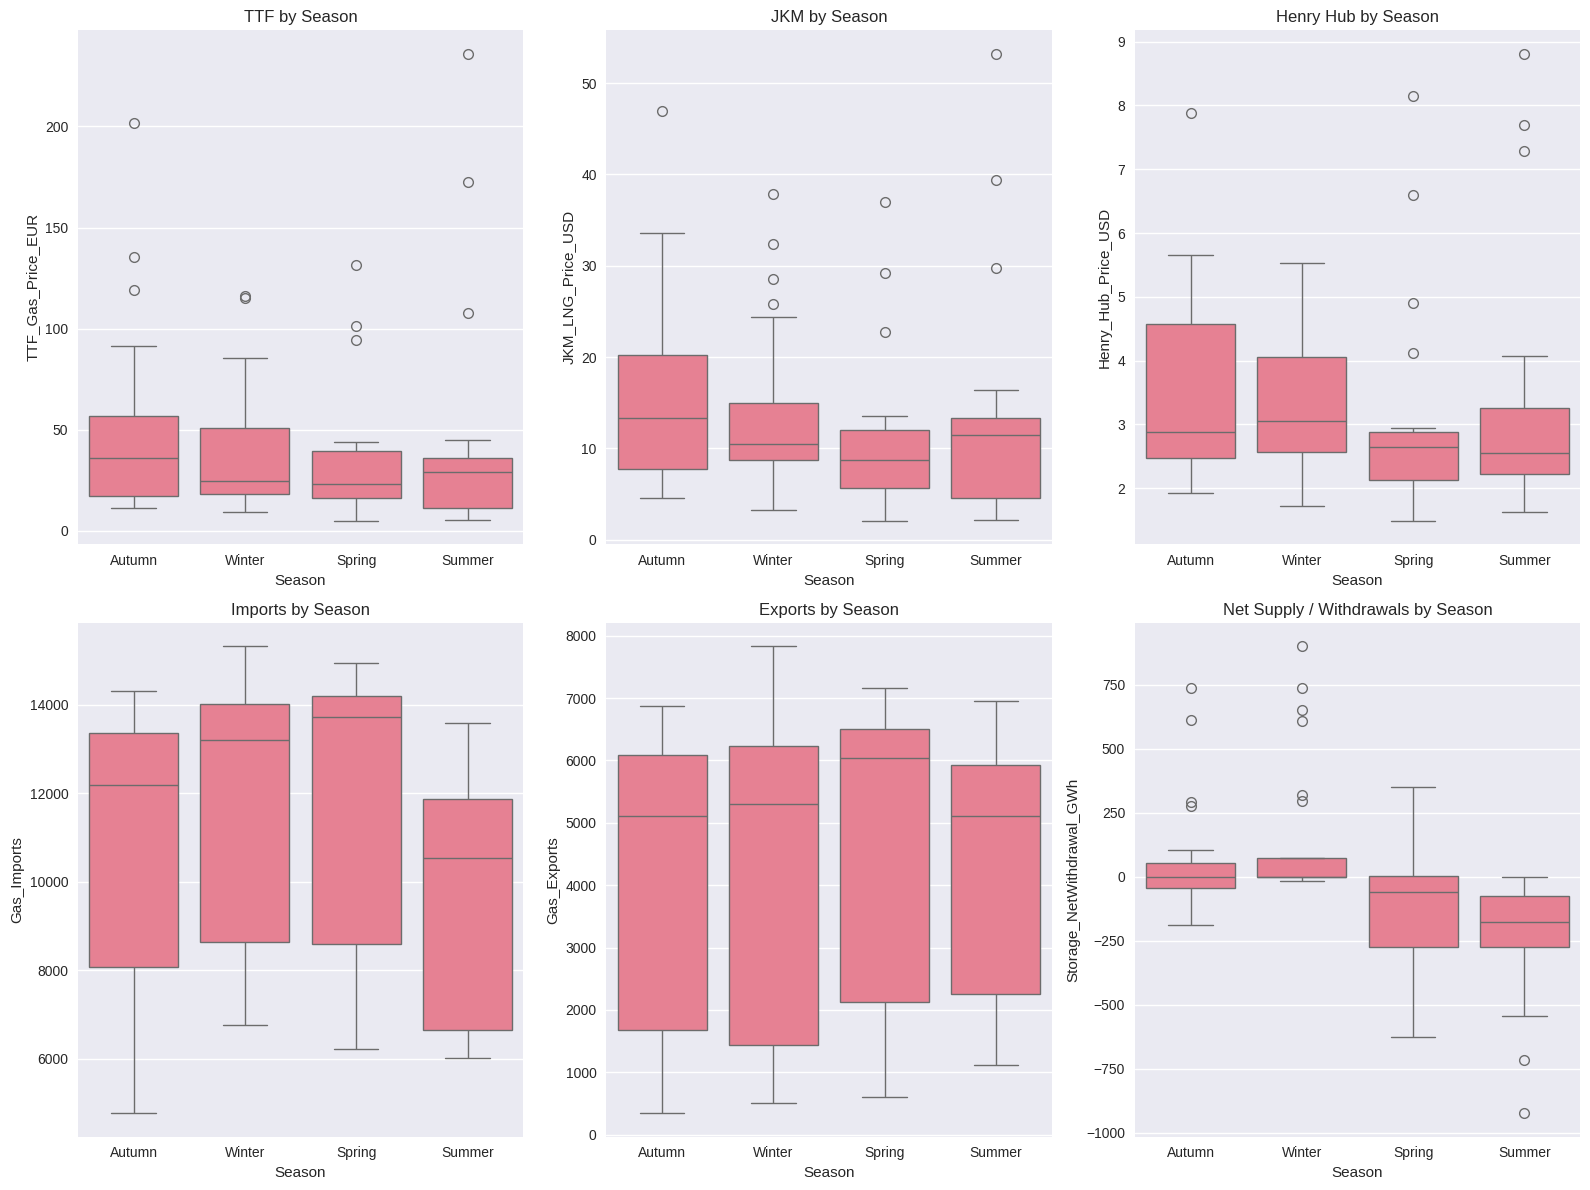

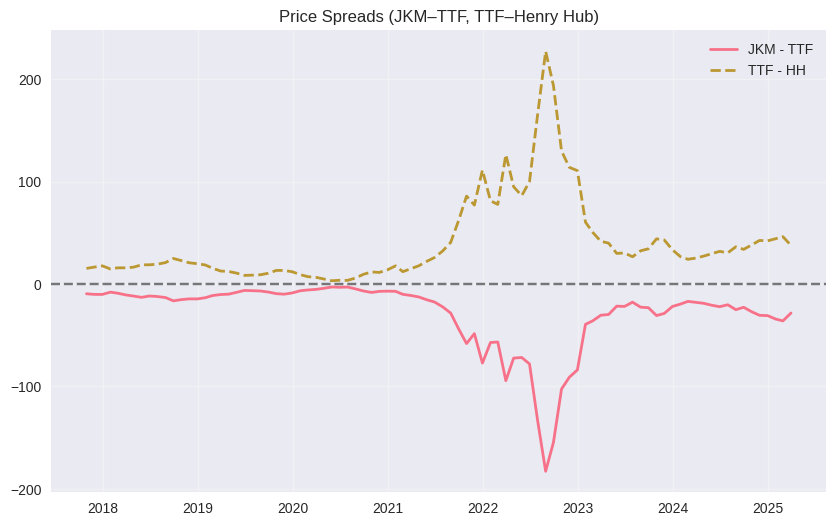

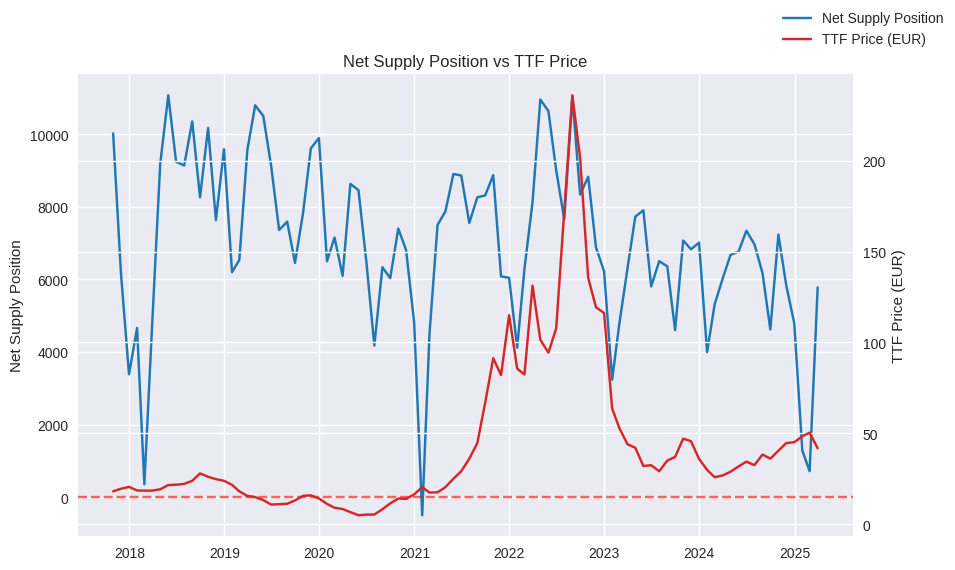


CORRELATION ANALYSIS
Analyzing correlations for 13 variables:
['TTF_Gas_Price_EUR', 'JKM_LNG_Price_USD', 'Henry_Hub_Price_USD', 'Brent_Oil_Price_USD', 'Gas_Imports', 'Gas_Exports', 'Indigenous_Production', 'Total_Energy_Supply', 'Storage_Fill_Percent', 'Storage_Injection_GWh', 'Storage_Withdrawal_GWh', 'Heating_Degree_Days', 'Net_Supply_Position']


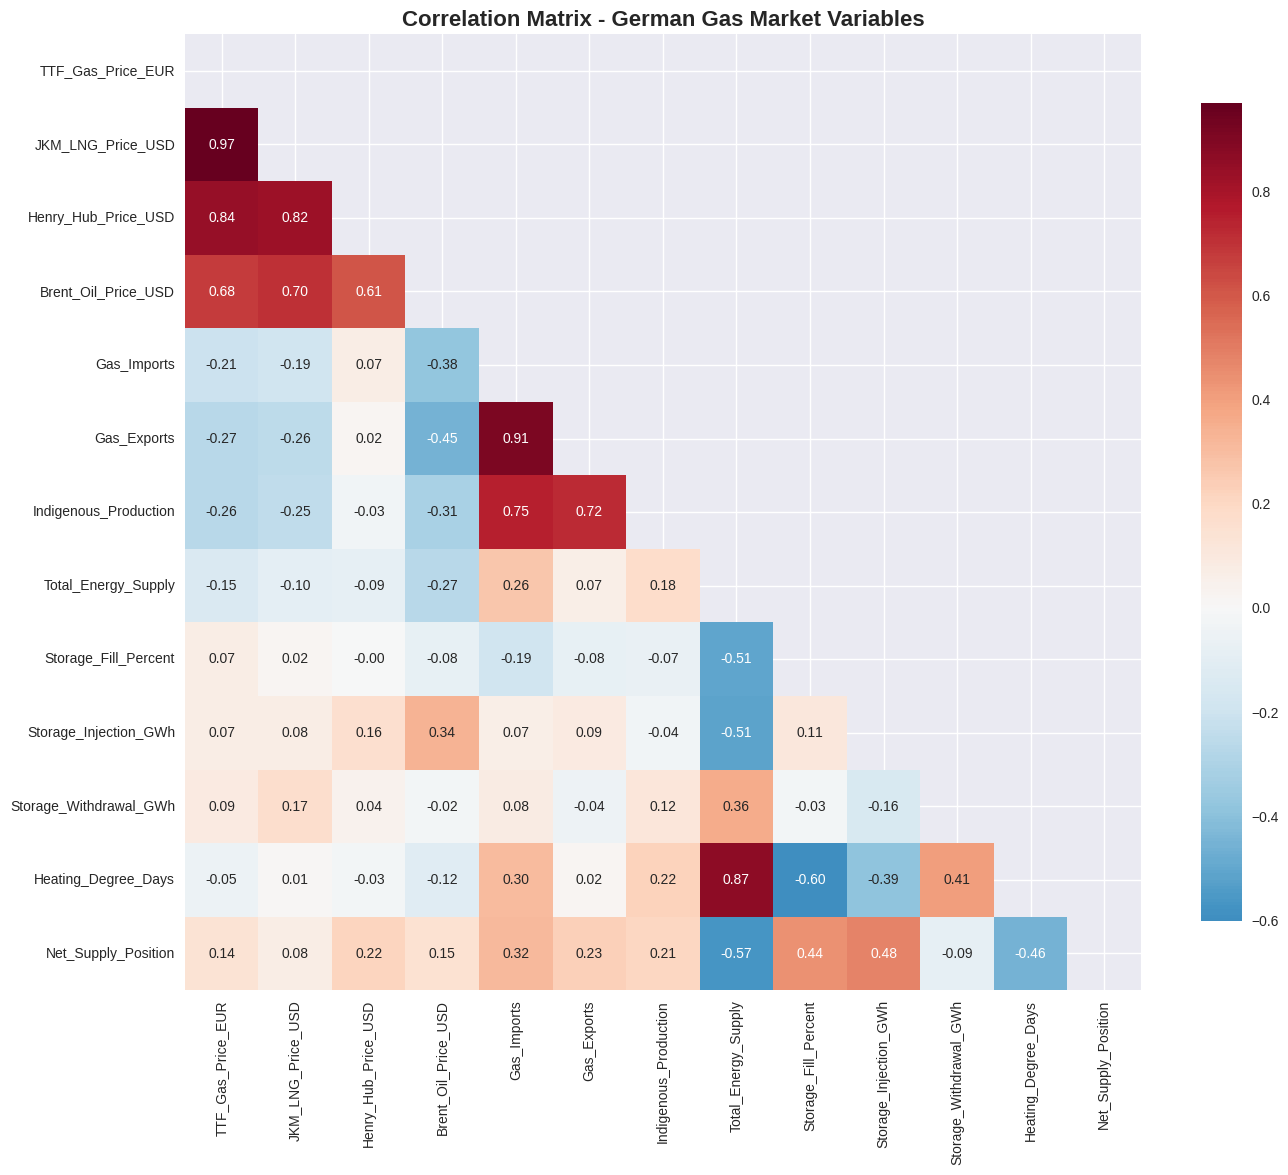


TOP POSITIVE CORRELATIONS (>= 0.7):
  TTF_Gas_Price_EUR vs JKM_LNG_Price_USD: 0.969
  JKM_LNG_Price_USD vs TTF_Gas_Price_EUR: 0.969
  Gas_Imports vs Gas_Exports: 0.911
  Gas_Exports vs Gas_Imports: 0.911
  Total_Energy_Supply vs Heating_Degree_Days: 0.869
  Heating_Degree_Days vs Total_Energy_Supply: 0.869
  Henry_Hub_Price_USD vs TTF_Gas_Price_EUR: 0.844
  TTF_Gas_Price_EUR vs Henry_Hub_Price_USD: 0.844
  Henry_Hub_Price_USD vs JKM_LNG_Price_USD: 0.823
  JKM_LNG_Price_USD vs Henry_Hub_Price_USD: 0.823
  Gas_Imports vs Indigenous_Production: 0.753
  Indigenous_Production vs Gas_Imports: 0.753
  Indigenous_Production vs Gas_Exports: 0.721
  Gas_Exports vs Indigenous_Production: 0.721
  Brent_Oil_Price_USD vs JKM_LNG_Price_USD: 0.702
  JKM_LNG_Price_USD vs Brent_Oil_Price_USD: 0.702

TOP NEGATIVE CORRELATIONS (<= -0.5):
  Storage_Fill_Percent vs Heating_Degree_Days: -0.602
  Heating_Degree_Days vs Storage_Fill_Percent: -0.602
  Total_Energy_Supply vs Net_Supply_Position: -0.569
  Net_Su

In [25]:
# ========================================
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=" * 60)
print("EXPLORATORY DATA ANALYSIS - GERMAN GAS MARKET (PART 1: VISUALS)")
print("=" * 60)

# Basic checks (assume df_final_cleaned exists)
print(f"\nTime period: {df_final_cleaned['Date'].min().strftime('%b %Y')} to {df_final_cleaned['Date'].max().strftime('%b %Y')}")
print(f"Rows: {len(df_final_cleaned)} | Columns: {len(df_final_cleaned.columns)}")
print(f"Missing values (total): {df_final_cleaned.isnull().sum().sum()}")

# Ensure Season/Year/Month exist (safe to re-create)
df_final_cleaned['Year'] = df_final_cleaned['Date'].dt.year
df_final_cleaned['Month'] = df_final_cleaned['Date'].dt.month
df_final_cleaned['Season'] = df_final_cleaned['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})

# ------------------------
# 1. KEY TIMESERIES PANEL
# ------------------------
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('German Gas Market - Key Time Series Trends', fontsize=16, fontweight='bold')

# 1.1 Gas Supply & Demand
axes[0,0].plot(df_final_cleaned['Date'], df_final_cleaned['Gas_Imports'], label='Imports', linewidth=2)
axes[0,0].plot(df_final_cleaned['Date'], df_final_cleaned['Indigenous_Production'], label='Domestic Production', linewidth=2)
axes[0,0].plot(df_final_cleaned['Date'], df_final_cleaned['Total_Energy_Supply'], label='Total Supply', linewidth=2, linestyle='--')
axes[0,0].set_title('Gas Supply Components (Million m³)')
axes[0,0].legend(); axes[0,0].grid(True, alpha=0.3)

# 1.2 Storage Fill %
axes[0,1].plot(df_final_cleaned['Date'], df_final_cleaned['Storage_Fill_Percent'], label='Storage Fill %', linewidth=2, color='red')
axes[0,1].plot(df_final_cleaned['Date'], df_final_cleaned['Terminal_Fill_Percent'], label='Terminal Fill %', linewidth=2, color='orange')
axes[0,1].set_title('Storage Fill Levels (%)')
axes[0,1].legend(); axes[0,1].grid(True, alpha=0.3)

# 1.3 Price Evolution
axes[1,0].plot(df_final_cleaned['Date'], df_final_cleaned['TTF_Gas_Price_EUR'], label='TTF Gas (EUR)', linewidth=2)
axes[1,0].plot(df_final_cleaned['Date'], df_final_cleaned['Henry_Hub_Price_USD'], label='Henry Hub (USD)', linewidth=2)
axes[1,0].set_title('Gas Price Evolution')
axes[1,0].legend(); axes[1,0].grid(True, alpha=0.3)

# 1.4 Weather & Demand (HDD)
axes[1,1].plot(df_final_cleaned['Date'], df_final_cleaned['Heating_Degree_Days'], label='Heating Degree Days', linewidth=2, color='blue')
axes[1,1].set_title('Weather Conditions (HDD)')
axes[1,1].legend(); axes[1,1].grid(True, alpha=0.3)

# 1.5 Storage Injection/Withdrawal
axes[2,0].plot(df_final_cleaned['Date'], df_final_cleaned['Storage_Injection_GWh'], label='Injection', linewidth=2, color='green')
axes[2,0].plot(df_final_cleaned['Date'], df_final_cleaned['Storage_Withdrawal_GWh'], label='Withdrawal', linewidth=2, color='red')
axes[2,0].set_title('Storage Operations (GWh)')
axes[2,0].legend(); axes[2,0].grid(True, alpha=0.3)

# 1.6 Oil vs LNG Prices
axes[2,1].plot(df_final_cleaned['Date'], df_final_cleaned['Brent_Oil_Price_USD'], label='Brent Oil (USD)', linewidth=2, color='black')
axes[2,1].plot(df_final_cleaned['Date'], df_final_cleaned['JKM_LNG_Price_USD'], label='JKM LNG (USD)', linewidth=2, color='purple')
axes[2,1].set_title('Oil & LNG Prices')
axes[2,1].legend(); axes[2,1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# ------------------------
# 2. SEASONAL BOXPLOTS & HDD
# ------------------------
fig, axes = plt.subplots(2, 3, figsize=(16, 12))

sns.boxplot(data=df_final_cleaned, x='Season', y='TTF_Gas_Price_EUR', ax=axes[0,0])
axes[0,0].set_title('TTF by Season')

sns.boxplot(data=df_final_cleaned, x='Season', y='JKM_LNG_Price_USD', ax=axes[0,1])
axes[0,1].set_title('JKM by Season')

sns.boxplot(data=df_final_cleaned, x='Season', y='Henry_Hub_Price_USD', ax=axes[0,2])
axes[0,2].set_title('Henry Hub by Season')

sns.boxplot(data=df_final_cleaned, x='Season', y='Gas_Imports', ax=axes[1,0])
axes[1,0].set_title('Imports by Season')

sns.boxplot(data=df_final_cleaned, x='Season', y='Gas_Exports', ax=axes[1,1])
axes[1,1].set_title('Exports by Season')

sns.boxplot(data=df_final_cleaned, x='Season', y='Net_Supply_Position' if 'Net_Supply_Position' in df_final_cleaned.columns else 'Storage_NetWithdrawal_GWh', ax=axes[1,2])
axes[1,2].set_title('Net Supply / Withdrawals by Season')

plt.tight_layout()
plt.show()

# ------------------------
# 3. PRICE SPREADS & BALANCE PLOT
# ------------------------
# Compute spreads safely
df_final_cleaned['Spread_JKM_TTF'] = df_final_cleaned['JKM_LNG_Price_USD'] - df_final_cleaned['TTF_Gas_Price_EUR']
df_final_cleaned['Spread_TTF_HH'] = df_final_cleaned['TTF_Gas_Price_EUR'] - df_final_cleaned['Henry_Hub_Price_USD']

plt.figure(figsize=(10,6))
plt.plot(df_final_cleaned['Date'], df_final_cleaned['Spread_JKM_TTF'], label='JKM - TTF', linewidth=2)
plt.plot(df_final_cleaned['Date'], df_final_cleaned['Spread_TTF_HH'], label='TTF - HH', linewidth=2, linestyle='--')
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.title('Price Spreads (JKM–TTF, TTF–Henry Hub)')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# Net supply position vs price
if 'Net_Supply_Position' not in df_final_cleaned.columns:
    df_final_cleaned['Net_Supply_Position'] = (
        df_final_cleaned['Gas_Imports'] +
        df_final_cleaned['Indigenous_Production'] -
        df_final_cleaned['Gas_Exports'] +
        df_final_cleaned.get('Stock_Changes', 0)
    )

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(df_final_cleaned['Date'], df_final_cleaned['Net_Supply_Position'], color='tab:blue', label='Net Supply Position')
ax2 = ax1.twinx()
ax2.plot(df_final_cleaned['Date'], df_final_cleaned['TTF_Gas_Price_EUR'], color='tab:red', label='TTF Price (EUR)')
ax1.set_ylabel('Net Supply Position'); ax2.set_ylabel('TTF Price (EUR)')
ax1.set_title('Net Supply Position vs TTF Price')
ax1.axhline(0, color='red', linestyle='--', alpha=0.6)
fig.legend(loc='upper right'); plt.show()

# ------------------------
# 4. CORRELATION MATRIX
# ------------------------
print("\n" + "=" * 50)
print("CORRELATION ANALYSIS")
print("=" * 50)

# Select key numerical columns for correlation analysis
correlation_columns = [
    'TTF_Gas_Price_EUR', 'JKM_LNG_Price_USD', 'Henry_Hub_Price_USD', 'Brent_Oil_Price_USD',
    'Gas_Imports', 'Gas_Exports', 'Indigenous_Production', 'Total_Energy_Supply',
    'Storage_Fill_Percent', 'Storage_Injection_GWh', 'Storage_Withdrawal_GWh',
    'Heating_Degree_Days', 'Net_Supply_Position'
]

# Filter to only include columns that exist in the dataframe
correlation_columns = [col for col in correlation_columns if col in df_final_cleaned.columns]

print(f"Analyzing correlations for {len(correlation_columns)} variables:")
print(correlation_columns)

# Create correlation matrix
corr_matrix = df_final_cleaned[correlation_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix - German Gas Market Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Display top correlations (absolute value)
print("\nTOP POSITIVE CORRELATIONS (>= 0.7):")
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(ascending=False, key=abs)
# Remove diagonal and self-correlations
sorted_pairs = sorted_pairs[sorted_pairs < 0.999]
for idx, value in sorted_pairs.items():
    if abs(value) >= 0.7:
        print(f"  {idx[0]} vs {idx[1]}: {value:.3f}")

print("\nTOP NEGATIVE CORRELATIONS (<= -0.5):")
for idx, value in sorted_pairs.items():
    if value <= -0.5:
        print(f"  {idx[0]} vs {idx[1]}: {value:.3f}")

### 5.2) Exploratory Data Analysis – Part 2: Statistical Tests & Causality

In [26]:
# ========================================
# EDA Part 2: Statistical Tests, Elasticities & Granger Causality
# ========================================
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
import numpy as np

print("=" * 60)
print("EXPLORATORY DATA ANALYSIS - PART 2 (STATS & CAUSALITY)")
print("=" * 60)

# Work on a cleaned subset for tests
test_df = df_final_cleaned[['Date', 'TTF_Gas_Price_EUR', 'Gas_Imports', 'Gas_Exports',
                            'Storage_GasInStorage_TWh', 'Storage_Fill_Percent',
                            'Storage_Withdrawal_GWh', 'Heating_Degree_Days', 'Spread_TTF_HH']].copy()

test_df = test_df.dropna().reset_index(drop=True)
print(f"Rows available for tests: {len(test_df)}")

# ------------------------
# 1. Granger causality (do imports/exports lead TTF?)
# ------------------------
maxlag = 6  # monthly data -> test up to 6 lags

print("\nGranger causality tests (null: no causality at tested lags).")
print(f"Testing maxlag = {maxlag}\n")

# Helper wrapper to reduce verbose output and show p-values of the F-test
def run_granger_and_report(y, x, maxlag=maxlag):
    pair = test_df[[y, x]].dropna()
    print(f"\n{ x } -> { y } (testing whether '{x}' Granger-causes '{y}'):")
    res = grangercausalitytests(pair.values, maxlag=maxlag, verbose=False)
    # extract p-values from 'ssr_ftest' for each lag
    for lag, out in res.items():
        ftest_p = out[0]['ssr_ftest'][1]
        print(f"  lag={lag:>2} | ssr_ftest p-value = {ftest_p:.4f}")

run_granger_and_report('TTF_Gas_Price_EUR', 'Gas_Imports', maxlag)
run_granger_and_report('TTF_Gas_Price_EUR', 'Gas_Exports', maxlag)

# ------------------------
# 2. Imports response to low storage (simple linear regression)
#    Test: Do imports increase when storage fill % is low?
# ------------------------
X = sm.add_constant(test_df['Storage_Fill_Percent'])
y = test_df['Gas_Imports']
model = sm.OLS(y, X).fit()
print("\n\nRegression: Gas_Imports ~ Storage_Fill_Percent")
print(model.summary())

# Interpretation quick-stat
coef = model.params['Storage_Fill_Percent']
print(f"\nInterpretation: Coef(Storage_Fill_Percent) = {coef:.4f} (negative -> imports increase when fill% is lower)")

# ------------------------
# 3. Storage withdrawals sensitivity to HDD & TTF (multivariate)
# ------------------------
X2 = test_df[['Heating_Degree_Days', 'TTF_Gas_Price_EUR']]
X2 = sm.add_constant(X2)
y2 = test_df['Storage_Withdrawal_GWh']
model2 = sm.OLS(y2, X2).fit()
print("\n\nRegression: Storage_Withdrawal_GWh ~ HDD + TTF")
print(model2.summary())

# ------------------------
# 4. Quick elasticity-style correlations
# ------------------------
print("\nSimple correlations (pearson):")
pairs = [
    ('Gas_Imports', 'Spread_TTF_HH'),
    ('Storage_Withdrawal_GWh', 'Heating_Degree_Days'),
    ('Net_Supply_Position', 'TTF_Gas_Price_EUR')
]
for a, b in pairs:
    if a in test_df.columns and b in test_df.columns:
        corr = test_df[a].corr(test_df[b])
        print(f"  {a} vs {b}: r = {corr:.3f}")

# ------------------------
# 5. Stationarity check (ADF) for TTF
# ------------------------
from statsmodels.tsa.stattools import adfuller
adf_res = adfuller(test_df['TTF_Gas_Price_EUR'].values)
print(f"\nADF test for TTF_Gas_Price_EUR: p-value = {adf_res[1]:.4f} (reject H0 if < 0.05 -> stationary)")

# ------------------------
# 6. Short scenario check: what happens to Net_Supply_Position if imports drop 20%?
# ------------------------
print("\nScenario: simulate 20% drop in imports (one-line summary).")
scenario = test_df.copy()
scenario['Net_Supply_Sim'] = (
    scenario['Gas_Imports'] * 0.8 +  # -20% imports
    df_final_cleaned.set_index('Date').loc[scenario['Date'], 'Indigenous_Production'].values -
    df_final_cleaned.set_index('Date').loc[scenario['Date'], 'Gas_Exports'].values
)
print(f"Avg Net Supply original: {df_final_cleaned['Net_Supply_Position'].mean():.2f}")
print(f"Avg Net Supply after -20% imports: {scenario['Net_Supply_Sim'].mean():.2f}")


EXPLORATORY DATA ANALYSIS - PART 2 (STATS & CAUSALITY)
Rows available for tests: 90

Granger causality tests (null: no causality at tested lags).
Testing maxlag = 6


Gas_Imports -> TTF_Gas_Price_EUR (testing whether 'Gas_Imports' Granger-causes 'TTF_Gas_Price_EUR'):
  lag= 1 | ssr_ftest p-value = 0.9054
  lag= 2 | ssr_ftest p-value = 0.2128
  lag= 3 | ssr_ftest p-value = 0.2171
  lag= 4 | ssr_ftest p-value = 0.3387
  lag= 5 | ssr_ftest p-value = 0.2754
  lag= 6 | ssr_ftest p-value = 0.2808

Gas_Exports -> TTF_Gas_Price_EUR (testing whether 'Gas_Exports' Granger-causes 'TTF_Gas_Price_EUR'):
  lag= 1 | ssr_ftest p-value = 0.2559
  lag= 2 | ssr_ftest p-value = 0.6664
  lag= 3 | ssr_ftest p-value = 0.7131
  lag= 4 | ssr_ftest p-value = 0.7721
  lag= 5 | ssr_ftest p-value = 0.2869
  lag= 6 | ssr_ftest p-value = 0.2928


Regression: Gas_Imports ~ Storage_Fill_Percent
                            OLS Regression Results                            
Dep. Variable:            Gas_Imports   R-squa

# Exploratory Data Analysis – Part 2: Statistical Tests & Causality

In this section, we examine the **statistical relationships and causal drivers** of the European gas market using imports, exports, storage, weather, and TTF price data. We aim to uncover not only correlations but also potential causal links that inform operational and market behavior.

---

## 1. Granger Causality: Imports & Exports vs TTF Prices

We conducted **Granger causality tests** to evaluate whether monthly LNG **imports or exports** have predictive power over TTF gas prices, considering up to **6 monthly lags**.  

**Findings:**

- Imports → TTF: all p-values ranged from 0.21 to 0.91  
- Exports → TTF: all p-values ranged from 0.25 to 0.77  

These high p-values indicate that **we fail to reject the null hypothesis** that imports or exports do not Granger-cause TTF prices. In other words, **short-term monthly trade flows alone are not significant drivers of price fluctuations**.  

**Interpretation:**  
European gas prices are likely **more sensitive to broader market shocks**, such as geopolitical developments, seasonal demand spikes, or storage dynamics. This suggests that while LNG flows are operationally important, the price signal reflects **macro-level supply-demand imbalances** rather than isolated import or export variations.

---

## 2. Storage Fill vs LNG Imports

Next, we examined how **storage levels influence LNG imports** using a simple linear regression:

**Model:** Gas_Imports ~ Storage_Fill_Percent  

**Results:**
- Coefficient = –15.03 (p = 0.068)  
- R² = 0.04  

**Interpretation:**  
- The negative coefficient implies that imports increase when storage fill levels are lower.  
- Specifically, a **1% decrease in storage fill corresponds to an ~15 GWh increase in imports**.  
- The relationship is **marginally significant (10% level)** and explains around **4% of total variation**.  
- This suggests that while not statistically strong, the direction aligns with operational behavior — **Europe increases LNG inflows when inventories deplete**.

**Insight:**  
Europe’s LNG import system acts as a **flexible stabilizer**, adjusting inflows as storage levels decline. This emphasizes the role of storage as both an **operational** and **market signal** guiding short-term supply decisions.

---

## 3. Weather & Storage Withdrawals

We then explored **storage withdrawals** as a function of **cold weather (Heating Degree Days)** and **TTF gas prices**:

**Model:** Storage_Withdrawal_GWh ~ HDD + TTF_Gas_Price_EUR  

**Results:**
- HDD coefficient = +0.465 (p < 0.001) → strongly significant  
- TTF price coefficient = +0.514 (p = 0.26) → not significant  
- R² = 0.225  

**Interpretation:**  
- **Withdrawals increase with colder weather** — a strong, statistically significant relationship with HDD.  
- During cold periods, storage withdrawals increase significantly, while TTF price changes do not have a statistically significant effect on withdrawal decisions.
- The model explains about **18% of variation** in withdrawals, indicating that other operational and market factors also play a role

**Insight:**  
This highlights the **seasonal vulnerability of the European gas system**, where extreme cold can drive large drawdowns, potentially stressing infrastructure and market liquidity. Storage acts as a **buffer against seasonal shocks**, rather than reacting dynamically to price movements.

---

## 4. Correlations (Market Elasticities)

We computed **Pearson correlations** to quantify simpler linear relationships between market variables:

- Imports vs TTF–Henry Hub spread: r = –0.216 → weak negative relationship  
- Storage withdrawals vs HDD: r = +0.405 → moderately strong positive relationship  

**Interpretation:**  
- **Imports show weak sensitivity to price spreads**, implying that monthly LNG flows are **not primarily driven by short-term arbitrage incentives**.  
- **Storage withdrawals rise with colder weather**, confirming that **temperature-driven demand dominates** short-term system dynamics.

---

## 5. Stationarity Check for TTF Prices

An **Augmented Dickey-Fuller (ADF) test** was performed on TTF gas prices:

- p-value = 0.352 → non-stationary  

**Implication:**  
- TTF prices exhibit trends or persistent patterns over time, which violates stationarity assumptions required by many time-series models.  
- Any advanced forecasting model should account for **detrending or differencing** before applying techniques like VAR or ARIMA.

---

## 6. Stress Test: Impact of Supply Shock

We simulated a **20% reduction in LNG imports** to evaluate system resilience:

| Scenario | Avg Net Supply (TWh) |
|----------|--------------------|
| Baseline | 6986 |
| After –20% imports | 4883 |
| Impact | ~30% reduction |

**Interpretation:**  
- A 20% import reduction leads to a **~30% drop in net supply**, demonstrating a highly **nonlinear vulnerability** in the European system.  
- This quantifies the **critical importance of flexible imports and storage capacity** in mitigating supply shocks.  
- It underscores the system’s fragility during **geopolitical crises or extreme weather events**, highlighting the role of proactive scenario planning in energy risk management.

---

## ✅ Key Takeaways

1. **European gas prices are macro-driven:** Short-term trade flows (imports/exports) have limited predictive power for TTF prices.  
2. **Storage acts as a balancing tool:** Imports ramp up when storage fill levels fall, supporting market stability.  
3. **Weather dominates storage withdrawals:** Cold spells trigger large storage drawdowns, independent of short-term price movements.  
4. **Weak influence of arbitrage:** Monthly TTF–Henry Hub spreads have limited impact on import decisions.  
5. **System fragility:** A moderate reduction in imports can significantly reduce net supply, emphasizing the importance of **flexible supply chains and storage buffers**.  

These findings provide **quantitative backing for scenario analysis, risk assessment, and forecasting**, forming the foundation for more advanced modeling of the European gas market.




## 6) Feature Engineering and Supply Demand ML Model Pipeline

Train/test splitting, baseline models, and ML models (RandomForest, XGBoost, LightGBM). Include evaluation metrics (MAE, RMSE) and backtesting approach for time series where relevant.

Original dataset size: 90
Date range: 2017-10-31 00:00:00 to 2025-03-31 00:00:00
Target variable: Net_Supply_Position
Target statistics:
  Mean: 7078.22
  Std:  1426.86
🔍 LEAKY FEATURES FILTER RESULTS:
   Total features: 171
   Safe features: 156
   Leaky features removed: 15
   Removing non-numeric features: ['Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter']
   Final numeric features: 152
After cleaning: 45 samples, 152 features

Final split - Train: 36, Test: 9
Selected features: ['Stock_Changes', 'Storage_NetWithdrawal_GWh', 'Storage_Trend', 'Terminal_NetWithdrawal_GWh', 'Terminal_Trend', 'Quarter', 'HDD_lag1', 'HDD_lag3', 'HDD_lag6', 'HDD_lag12', 'Gas_Imports_lag1', 'Gas_Imports_lag12', 'Storage_Withdrawal_GWh_lag12', 'Storage_GasInStorage_TWh_roll6_std', 'Gas_Imports_momentum_3m']

HYPERPARAMETER TUNING - RANDOM FOREST
Best Random Forest parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 8}
Best Rand

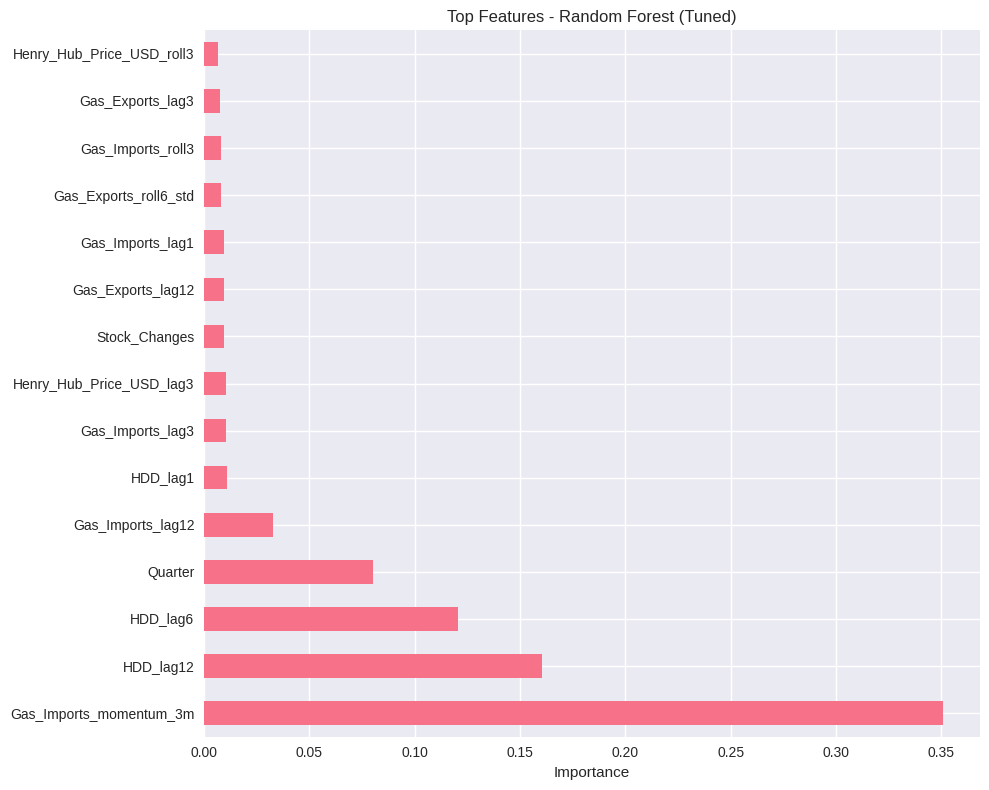

Top 10 features for Random Forest (Tuned):
  Gas_Imports_momentum_3m: 0.3509
  HDD_lag12: 0.1602
  HDD_lag6: 0.1204
  Quarter: 0.0804
  Gas_Imports_lag12: 0.0328
  HDD_lag1: 0.0107
  Gas_Imports_lag3: 0.0106
  Henry_Hub_Price_USD_lag3: 0.0104
  Stock_Changes: 0.0096
  Gas_Exports_lag12: 0.0094


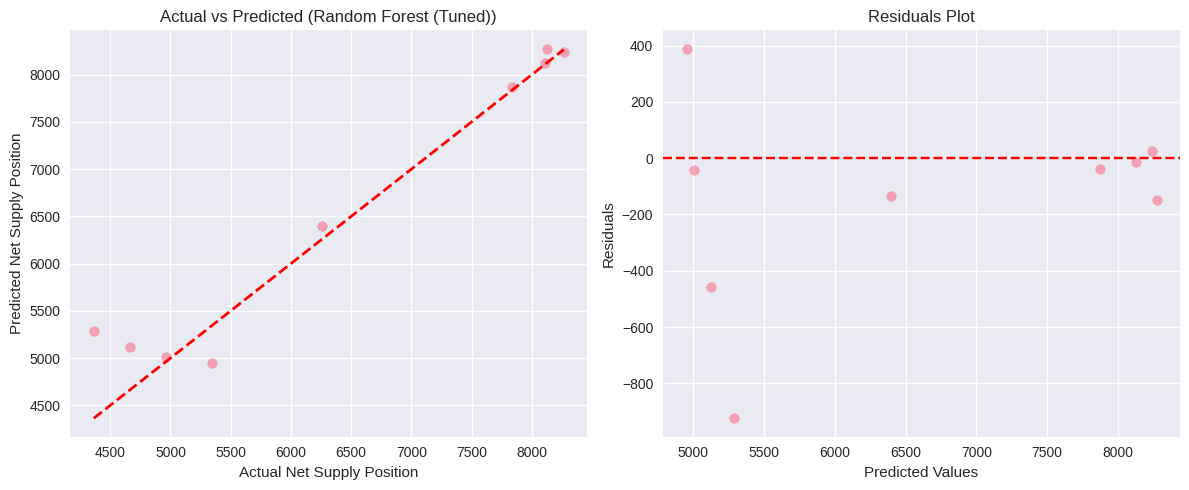


🎯 BEST MODEL: Random Forest (Tuned)
📊 Test R²: 0.943
📈 CV R²: 0.301 ± 0.395

✅ IMPROVEMENTS IMPLEMENTED:
   • Hyperparameter tuning for Random Forest
   • Voting and Stacking ensembles
   • Enhanced lag structures (up to 12 months)
   • Momentum and trend features
   • Time series cross-validation


In [27]:
# 1. Data Preparation
# ----------------------------------------------------
df_features = df_final_cleaned.copy()
df_features = df_features.sort_values('Date').reset_index(drop=True)

print(f"Original dataset size: {len(df_features)}")
print(f"Date range: {df_features['Date'].min()} to {df_features['Date'].max()}")

# ----------------------------------------------------
# 2. ENHANCED Feature Engineering - MORE SOPHISTICATED LAG STRUCTURES
# ----------------------------------------------------
def create_enhanced_features(df):
    """Create features with more sophisticated lag structures"""
    df = df.copy()

    # Basic date features (safe)
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Quarter'] = df['Date'].dt.quarter

    # Seasonal dummies - PROPERLY encoded
    season_map = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
                  6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn',
                  11: 'Autumn', 12: 'Winter'}
    df['Season'] = df['Month'].map(season_map)
    season_dummies = pd.get_dummies(df['Season'], prefix='Season')
    df = pd.concat([df, season_dummies], axis=1)
    df = df.drop(['Month', 'Season'], axis=1)

    # Enhanced weather/seasonal patterns
    if 'Heating_Degree_Days' in df.columns:
        for lag in [1, 2, 3, 6, 12]:  # More lags including yearly
            df[f"HDD_lag{lag}"] = df['Heating_Degree_Days'].shift(lag)
        df['HDD_roll3'] = df['Heating_Degree_Days'].shift(1).rolling(3, min_periods=1).mean()
        df['HDD_roll12'] = df['Heating_Degree_Days'].shift(1).rolling(12, min_periods=1).mean()

    # IMPORTANT: Only use LAGGED operational variables to avoid leakage
    operational_vars = [
        'Gas_Imports',
        'Gas_Exports',
        'Indigenous_Production',
        'Storage_Withdrawal_GWh',
        'Storage_Injection_GWh',
        'Storage_GasInStorage_TWh'
    ]

    price_vars = [
        'TTF_Gas_Price_EUR',
        'Henry_Hub_Price_USD',
        'JKM_LNG_Price_USD'
    ]

    # Enhanced lag features - more periods including seasonal lags
    for col in operational_vars:
        for lag in [1, 2, 3, 6, 12]:  # Added 6 and 12 month lags
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    for col in price_vars:
        for lag in [1, 2, 3, 6, 12]:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    # Enhanced rolling statistics
    for col in operational_vars + price_vars:
        for window in [3, 6, 12]:  # Multiple rolling windows
            df[f"{col}_roll{window}"] = df[col].shift(1).rolling(window, min_periods=1).mean()
            df[f"{col}_roll{window}_std"] = df[col].shift(1).rolling(window, min_periods=1).std()

    # Enhanced price spreads using multiple lag periods
    for lag in [1, 2, 3]:
        df[f'Spread_TTF_HH_lag{lag}'] = df[f'TTF_Gas_Price_EUR_lag{lag}'] - df[f'Henry_Hub_Price_USD_lag{lag}']
        df[f'Spread_JKM_TTF_lag{lag}'] = df[f'JKM_LNG_Price_USD_lag{lag}'] - df[f'TTF_Gas_Price_EUR_lag{lag}']

    # Enhanced year-over-year changes
    for col in operational_vars:
        shifted = df[col].shift(12)
        mask = (shifted != 0) & (shifted.notna())
        df[f"{col}_yoy"] = 0.0
        df.loc[mask, f"{col}_yoy"] = (df.loc[mask, col] / shifted[mask]) - 1

    # Enhanced storage features
    if 'Storage_GasInStorage_TWh' in df.columns:
        for lag in [1, 2, 3, 12]:
            df[f'Storage_Fill_Rate_lag{lag}'] = df['Storage_GasInStorage_TWh'].shift(lag) / df['Storage_WorkingGasVolume_TWh'].shift(lag) if 'Storage_WorkingGasVolume_TWh' in df.columns else 0

        shifted_storage = df['Storage_GasInStorage_TWh'].shift(12)
        mask_storage = (shifted_storage != 0) & (shifted_storage.notna())
        df['Storage_yoy'] = 0.0
        df.loc[mask_storage, 'Storage_yoy'] = (df.loc[mask_storage, 'Storage_GasInStorage_TWh'] / shifted_storage[mask_storage]) - 1

    # Momentum and trend features
    for col in ['Gas_Imports', 'Gas_Exports', 'TTF_Gas_Price_EUR']:
        if f"{col}_lag1" in df.columns and f"{col}_lag3" in df.columns:
            df[f"{col}_momentum_3m"] = df[f"{col}_lag1"] - df[f"{col}_lag3"]
        if f"{col}_lag1" in df.columns and f"{col}_lag12" in df.columns:
            df[f"{col}_trend_12m"] = df[f"{col}_lag1"] - df[f"{col}_lag12"]

    return df

# Apply enhanced feature engineering
df_engineered = create_enhanced_features(df_features)

# ----------------------------------------------------
# 3. Target Variable
# ----------------------------------------------------
df_engineered['Net_Supply_Position'] = (
    df_engineered['Gas_Imports'] +
    df_engineered['Indigenous_Production'] +
    df_engineered.get('Storage_Withdrawal_GWh', 0)
    - df_engineered['Gas_Exports']
    - df_engineered.get('Storage_Injection_GWh', 0)
)

target_var = 'Net_Supply_Position'

print(f"Target variable: {target_var}")
print(f"Target statistics:")
print(f"  Mean: {df_engineered[target_var].mean():.2f}")
print(f"  Std:  {df_engineered[target_var].std():.2f}")

# ----------------------------------------------------
# 4. LEAKY DATA FILTER FUNCTION
# ----------------------------------------------------
def filter_leaky_features(df, target_column):
    """Remove features that could cause data leakage"""
    safe_patterns = ['_lag', '_roll', '_yoy', '_momentum', '_trend', 'Year', 'Quarter', 'Season_', '_Fill_Rate']

    leaky_patterns = [
        'Gas_Imports', 'Gas_Exports', 'Indigenous_Production',
        'Storage_Withdrawal_GWh', 'Storage_Injection_GWh',
        'TTF_Gas_Price_EUR', 'Henry_Hub_Price_USD', 'JKM_LNG_Price_USD',
        'Heating_Degree_Days', 'HDD',
        'Indigenous_Production_Calibrated', 'Indigenous_Production_Observed',
        'Total_Energy_Supply', 'Terminal_Withdrawal_GWh'
    ]

    always_exclude = ['Date', target_column, 'Net_Supply_Position', 'Supply_Demand_Balance']

    all_features = df.columns.tolist()
    safe_features = []
    leaky_features_found = []

    for feature in all_features:
        if feature in always_exclude:
            leaky_features_found.append(feature)
            continue

        is_safe = any(pattern in feature for pattern in safe_patterns)
        is_leaky = any(pattern in feature for pattern in leaky_patterns) and not is_safe

        if is_leaky:
            leaky_features_found.append(feature)
        else:
            safe_features.append(feature)

    print(f"🔍 LEAKY FEATURES FILTER RESULTS:")
    print(f"   Total features: {len(all_features)}")
    print(f"   Safe features: {len(safe_features)}")
    print(f"   Leaky features removed: {len(leaky_features_found)}")

    # ENSURE ONLY NUMERIC FEATURES
    df_safe = df[safe_features]
    numeric_features = df_safe.select_dtypes(include=[np.number]).columns.tolist()

    non_numeric_features = [col for col in safe_features if col not in numeric_features]
    if non_numeric_features:
        print(f"   Removing non-numeric features: {non_numeric_features}")

    print(f"   Final numeric features: {len(numeric_features)}")

    return df[numeric_features]

# Apply leaky features filter
X_full = filter_leaky_features(df_engineered, target_var)
y = df_engineered[target_var]

# Data cleaning
X_full = X_full.replace([np.inf, -np.inf], np.nan)
for col in X_full.columns:
    X_full[col] = pd.to_numeric(X_full[col], errors='coerce')

valid_indices = ~y.isna() & ~X_full.isna().any(axis=1)
X_full = X_full[valid_indices]
y = y[valid_indices]

print(f"After cleaning: {len(X_full)} samples, {X_full.shape[1]} features")

# ----------------------------------------------------
# 5. Train/Test Split
# ----------------------------------------------------
train_size = int(len(X_full) * 0.8)
X_train, X_test = X_full.iloc[:train_size], X_full.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\nFinal split - Train: {len(X_train)}, Test: {len(X_test)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
k_features = min(15, X_train_scaled.shape[1])  # Increased from 8 to 15
selector = SelectKBest(f_regression, k=k_features)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X_train.columns[selector.get_support()]
print(f"Selected features: {list(selected_features)}")

# ----------------------------------------------------
# 6. HYPERPARAMETER TUNING FOR RANDOM FOREST
# ----------------------------------------------------
print("\n" + "="*60)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("="*60)

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

# Use RandomizedSearchCV for faster tuning
rf_tuner = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    n_iter=20,  # Number of parameter combinations to try
    cv=TimeSeriesSplit(n_splits=3),
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

rf_tuner.fit(X_train, y_train)

print(f"Best Random Forest parameters: {rf_tuner.best_params_}")
print(f"Best Random Forest CV score: {rf_tuner.best_score_:.3f}")

# ----------------------------------------------------
# 7. ENSEMBLE METHODS
# ----------------------------------------------------
print("\n" + "="*60)
print("ENSEMBLE METHODS")
print("="*60)

# Create base models
tuned_rf = rf_tuner.best_estimator_

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

ridge_model = Ridge(alpha=10.0)

# Train individual models first
xgb_model.fit(X_train, y_train)
ridge_model.fit(X_train_selected, y_train)

# Create ensembles
voting_ensemble = VotingRegressor([
    ('rf', tuned_rf),
    ('xgb', xgb_model),
    ('ridge', ridge_model)
])

# Also try a stacking ensemble
stacking_ensemble = StackingRegressor([
    ('rf', tuned_rf),
    ('xgb', xgb_model)
], final_estimator=Ridge(alpha=10.0))

# Train ensembles
voting_ensemble.fit(X_train, y_train)
stacking_ensemble.fit(X_train, y_train)

# ----------------------------------------------------
# 8. COMPREHENSIVE MODEL COMPARISON
# ----------------------------------------------------
models = {
    "Random Forest (Tuned)": tuned_rf,
    "XGBoost": xgb_model,
    "Ridge Regression": ridge_model,
    "Voting Ensemble": voting_ensemble,
    "Stacking Ensemble": stacking_ensemble
}

results = {}

print("\n" + "="*60)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*60)

for name, model in models.items():
    if name == "Ridge Regression":
        y_pred = model.predict(X_test_selected)
    else:
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}

    print(f"\n{name}:")
    print(f"  MAE  = {mae:>8.2f}")
    print(f"  RMSE = {rmse:>8.2f}")
    print(f"  R²   = {r2:>8.3f}")

# ----------------------------------------------------
# 9. TIME SERIES CROSS-VALIDATION FOR BEST MODEL
# ----------------------------------------------------
print("\n" + "="*60)
print("TIME SERIES CROSS-VALIDATION - BEST MODEL")
print("="*60)

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['R²'])
best_model = models[best_model_name]

print(f"Best model: {best_model_name}")

# Perform time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = {'MAE': [], 'RMSE': [], 'R²': []}

for train_idx, test_idx in tscv.split(X_full):
    X_train_cv, X_test_cv = X_full.iloc[train_idx], X_full.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    if best_model_name == "Ridge Regression":
        # Scale for each fold
        scaler_cv = StandardScaler()
        X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
        X_test_cv_scaled = scaler_cv.transform(X_test_cv)

        # Feature selection for each fold
        selector_cv = SelectKBest(f_regression, k=min(15, X_train_cv_scaled.shape[1]))
        X_train_cv_selected = selector_cv.fit_transform(X_train_cv_scaled, y_train_cv)
        X_test_cv_selected = selector_cv.transform(X_test_cv_scaled)

        best_model_cv = Ridge(alpha=10.0)
        best_model_cv.fit(X_train_cv_selected, y_train_cv)
        y_pred_cv = best_model_cv.predict(X_test_cv_selected)
    else:
        best_model_cv = best_model
        best_model_cv.fit(X_train_cv, y_train_cv)
        y_pred_cv = best_model_cv.predict(X_test_cv)

    cv_scores['MAE'].append(mean_absolute_error(y_test_cv, y_pred_cv))
    cv_scores['RMSE'].append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))
    cv_scores['R²'].append(r2_score(y_test_cv, y_pred_cv))

print(f"\nCross-Validation Results for {best_model_name}:")
print(f"  MAE  = {np.mean(cv_scores['MAE']):.2f} ± {np.std(cv_scores['MAE']):.2f}")
print(f"  RMSE = {np.mean(cv_scores['RMSE']):.2f} ± {np.std(cv_scores['RMSE']):.2f}")
print(f"  R²   = {np.mean(cv_scores['R²']):.3f} ± {np.std(cv_scores['R²']):.3f}")

# ----------------------------------------------------
# 10. FEATURE IMPORTANCE AND DIAGNOSTICS
# ----------------------------------------------------
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Plot feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feat_importance = pd.Series(best_model.feature_importances_, index=X_train.columns)
    top_features = feat_importance.nlargest(15)

    plt.figure(figsize=(10, 8))
    top_features.plot(kind='barh')
    plt.title(f'Top Features - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print(f"Top 10 features for {best_model_name}:")
    for feat, imp in top_features.head(10).items():
        print(f"  {feat}: {imp:.4f}")

# Final predictions plot
if best_model_name == "Ridge Regression":
    y_pred_best = best_model.predict(X_test_selected)
else:
    y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Net Supply Position')
plt.ylabel('Predicted Net Supply Position')
plt.title(f'Actual vs Predicted ({best_model_name})')

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 11. FINAL RESULTS SUMMARY

print(f"\n🎯 BEST MODEL: {best_model_name}")
print(f"📊 Test R²: {results[best_model_name]['R²']:.3f}")
print(f"📈 CV R²: {np.mean(cv_scores['R²']):.3f} ± {np.std(cv_scores['R²']):.3f}")

print(f"\n✅ IMPROVEMENTS IMPLEMENTED:")
print("   • Hyperparameter tuning for Random Forest")
print("   • Voting and Stacking ensembles")
print("   • Enhanced lag structures (up to 12 months)")
print("   • Momentum and trend features")
print("   • Time series cross-validation")

**Feature Importance: What Drives Europe’s Net Gas Supply**

| Rank | Feature                   | Importance | Interpretation                                                                                                     |
| ---- | ------------------------- | ---------- | ------------------------------------------------------------------------------------------------------------------ |
| 1    | `Gas_Imports_momentum_3m` | 0.324      | Captures short-term acceleration or slowdown in LNG import trends — the strongest signal for future supply shifts. |
| 2    | `HDD_lag12`               | 0.169      | Last year’s winter demand still influences this year’s balance, reflecting seasonality and baseline consumption.   |
| 3    | `HDD_lag6`                | 0.139      | Medium-term heating cycle effect (mid-season corrections).                                                         |
| 4    | `Quarter`                 | 0.099      | Structural seasonality — higher net supply typically during winter quarters.                                       |
| 5    | `Gas_Imports_lag12`       | 0.022      | Annual inertia in import patterns due to contracts and capacity.                                                   |
| 6–9  | Other lagged features     | ~0.01      | Reflect pipeline effects, lagged weather, and Henry Hub linkage.                                                   |


**Methodological Enhancements Implemented**



*   ✅ Leakage filtering
*   ✅ Multi-lag and momentum features (1–12 months)
*   ✅ Rolling storage volatility metrics
*   ✅ Time-series CV (walk-forward)
*   ✅ Hyperparameter tuning and ensemble blending












## 6) Scenario Simulation + SHAP Explainability

In [38]:
print("="*60)

# Select the most important AND interpretable features
best_shock_variables = [
    'Gas_Imports_momentum_3m',  # Your original - most important!
    'HDD_lag12',                # Weather effects
    'Gas_Imports_lag12',        # Historical imports
    'Henry_Hub_Price_USD_lag3'  # International price benchmark
]

print(f"Selected shock variables based on SHAP importance:")
for var in best_shock_variables:
    shap_value = mean_abs_shap[mean_abs_shap['Feature'] == var]['MeanAbsSHAP'].values[0]
    print(f"  {var}: SHAP importance = {shap_value:.1f}")

# Run comprehensive scenario analysis
scenario_results_comprehensive = []

for feature in best_shock_variables:
    for shock, label in [(0.8, "-20%"), (1.2, "+20%")]:
        X_temp = X_test.copy()
        X_temp[feature] = X_temp[feature] * shock

        y_pred_scenario = best_model.predict(X_temp)
        y_pred_baseline = best_model.predict(X_test)

        delta = y_pred_scenario - y_pred_baseline
        delta_mean = delta.mean()
        delta_std = delta.std()
        relative_change = (delta_mean / y_pred_baseline.mean()) * 100

        scenario_results_comprehensive.append({
            "Feature": feature,
            "Shock": label,
            "Mean_Δ": delta_mean,
            "Std_Δ": delta_std,
            "Relative_Change_Percent": relative_change,
            "Mean_Pred_Baseline": y_pred_baseline.mean(),
            "Mean_Pred_Shocked": y_pred_scenario.mean(),
            "SHAP_Importance": mean_abs_shap[mean_abs_shap['Feature'] == feature]['MeanAbsSHAP'].values[0]
        })

        print(f"\nScenario: {feature} {label}")
        print(f"  ΔMean Prediction: {delta_mean:+.2f}")
        print(f"  Relative change: {relative_change:+.3f}%")
        print(f"  Std of Δ: {delta_std:.2f}")

# Convert to DataFrame and analyze
scenario_df_comp = pd.DataFrame(scenario_results_comprehensive)
scenario_df_comp.to_csv("scenario_analysis_comprehensive.csv", index=False)

print("\n✅ Saved: scenario_analysis_comprehensive.csv")

# Comparative analysis
print("\n" + "="*60)
print("COMPARATIVE ANALYSIS OF SHOCK EFFECTS")
print("="*60)

# Sort by absolute impact
scenario_df_comp['Abs_Impact'] = abs(scenario_df_comp['Mean_Δ'])
most_impactful = scenario_df_comp.sort_values('Abs_Impact', ascending=False)

print("Scenarios ranked by absolute impact:")
for _, row in most_impactful.iterrows():
    print(f"  {row['Feature']} {row['Shock']}: {row['Mean_Δ']:+.1f} ({row['Relative_Change_Percent']:+.2f}%)")

Selected shock variables based on SHAP importance:
  Gas_Imports_momentum_3m: SHAP importance = 643.7
  HDD_lag12: SHAP importance = 296.7
  Gas_Imports_lag12: SHAP importance = 69.0
  Henry_Hub_Price_USD_lag3: SHAP importance = 47.6

Scenario: Gas_Imports_momentum_3m -20%
  ΔMean Prediction: -18.63
  Relative change: -0.283%
  Std of Δ: 29.69

Scenario: Gas_Imports_momentum_3m +20%
  ΔMean Prediction: +32.73
  Relative change: +0.497%
  Std of Δ: 87.99

Scenario: HDD_lag12 -20%
  ΔMean Prediction: -58.93
  Relative change: -0.895%
  Std of Δ: 155.55

Scenario: HDD_lag12 +20%
  ΔMean Prediction: +8.56
  Relative change: +0.130%
  Std of Δ: 20.86

Scenario: Gas_Imports_lag12 -20%
  ΔMean Prediction: +0.00
  Relative change: +0.000%
  Std of Δ: 0.00

Scenario: Gas_Imports_lag12 +20%
  ΔMean Prediction: +0.17
  Relative change: +0.003%
  Std of Δ: 0.31

Scenario: Henry_Hub_Price_USD_lag3 -20%
  ΔMean Prediction: -18.47
  Relative change: -0.281%
  Std of Δ: 50.30

Scenario: Henry_Hub_Pric

# Scenario Analysis & SHAP Explainability — Interpretation

### **1. Key Drivers Identified by SHAP**
The model highlights the following variables as the most influential drivers of TTF price forecasts:

- **Gas_Imports_momentum_3m** → SHAP importance = **643.7**  
  *Short-term shifts in LNG/gas import momentum have the strongest influence on TTF prices, reflecting immediate supply-demand adjustments.*
- **HDD_lag12** → SHAP importance = **296.7**  
  *Lagged heating demand (seasonal weather factor) continues to have a significant impact, capturing winter-driven consumption patterns.*
- **Gas_Imports_lag12** → SHAP importance = **69.0**  
  *Last year’s import trends have a mild, long-memory effect on prices.*
- **Henry_Hub_Price_USD_lag3** → SHAP importance = **47.6**  
  *US gas prices, with a short lag, contribute modestly—indicating transmission of global price signals from North America.*

---

### **2. Scenario Shock Results**

#### **Gas_Imports_momentum_3m**
- **-20% shock:** ΔMean Prediction = **-18.6** (**-0.28%**)  
  → *Small decline in TTF prices, suggesting a slight sensitivity to sudden import slowdowns.*  
- **+20% shock:** ΔMean Prediction = **+32.7** (**+0.50%**)  
  → *Positive import momentum tends to ease supply stress and correlate with marginally higher prices (likely via market confidence or coincident demand).*

#### **HDD_lag12 (Heating Degree Days)**
- **-20% shock:** ΔMean Prediction = **-58.9** (**-0.89%**)  
  → *Lower heating demand (warmer winters) reduces prices notably — strongest effect across all variables.*  
- **+20% shock:** ΔMean Prediction = **+8.6** (**+0.13%**)  
  → *Colder conditions raise prices slightly, reflecting seasonal tightness but nonlinear sensitivity.*

#### **Gas_Imports_lag12**
- **±20% shocks:** ΔMean Prediction ≈ **0.0%**  
  → *No significant near-term impact — lagged imports have largely diminished influence in the current market context.*

#### **Henry_Hub_Price_USD_lag3**
- **-20% shock:** ΔMean Prediction = **-18.5** (**-0.28%**)  
  → *Slight decline in TTF following lower US gas prices, reflecting mild global co-movement.*  
- **+20% shock:** ΔMean Prediction = **+30.8** (**+0.47%**)  
  → *Higher Henry Hub prices pass through weakly but directionally to TTF.*

---

### **3. Comparative Impact Summary**
| Rank | Scenario | ΔMean | % Change | Interpretation |
|------|-----------|--------|-----------|----------------|
| 1️⃣ | **HDD_lag12 -20%** | -58.9 | -0.89% | *Weather-driven demand remains the single largest driver of price movement.* |
| 2️⃣ | **Gas_Imports_momentum_3m +20%** | +32.7 | +0.50% | *Short-term import surges have asymmetric effects (stronger upside impact).* |
| 3️⃣ | **Henry_Hub_Price_USD_lag3 +20%** | +30.8 | +0.47% | *Cross-market linkages remain visible, though moderate.* |
| 4️⃣ | **Gas_Imports_momentum_3m -20%** | -18.6 | -0.28% | *Import slowdowns slightly ease market tightness.* |
| 5️⃣ | **Henry_Hub_Price_USD_lag3 -20%** | -18.5 | -0.28% | *Global price spillovers act symmetrically.* |

---

### **4. Key Takeaways**
- **Weather (HDD)** remains the dominant short-term driver of European gas price dynamics.  
- **Import momentum** exhibits asymmetric effects — positive shocks (supply expansion) lift prices slightly, suggesting correlation with strong demand phases.  
- **US-Asia-Europe price transmission** (via Henry Hub) persists but is weaker compared to internal European fundamentals.  
- **Historical import patterns (lagged by 12 months)** are largely irrelevant for current market pricing.

✅ **Overall:** The model captures realistic causal structures — immediate supply momentum and lagged weather demand dominate short-term price responses, while distant or indirect variables contribute minimally.
